In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image

# =======================
# 1. 모델 로드
# =======================
processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# =======================
# 2. 부드러운 마스크 적용 함수
# =======================
def smooth_mask(mask, blur_size=21):
    mask_float = mask.astype(np.float32)
    mask_blur = cv2.GaussianBlur(mask_float, (blur_size, blur_size), 0)
    mask_norm = mask_blur / mask_blur.max() if mask_blur.max() > 0 else mask_blur
    return mask_norm

def apply_smooth_mask(image, mask, color, alpha=0.5, blur_size=21):
    smooth = smooth_mask(mask, blur_size)
    overlay = np.zeros_like(image, dtype=np.float32)
    overlay[:] = color
    blended = image.astype(np.float32) * (1 - alpha * smooth[..., None]) + overlay * (alpha * smooth[..., None])
    return blended.astype(np.uint8)

# =======================
# 3. 눈두덩이 마스크 생성 함수
# =======================
def create_eyelid_mask(mask_resized, eye_label, brow_label, top_offset=2, bottom_offset=2):
    eye_coords = np.column_stack(np.where(mask_resized == eye_label))
    brow_coords = np.column_stack(np.where(mask_resized == brow_label))
    if len(eye_coords) == 0 or len(brow_coords) == 0:
        return np.zeros_like(mask_resized, dtype=bool)

    all_coords = np.vstack((eye_coords, brow_coords))
    min_y = int(min(eye_coords[:,0].min(), brow_coords[:,0].min()) + top_offset)
    max_y = int(max(eye_coords[:,0].max(), brow_coords[:,0].max()) - bottom_offset)
    region_coords = all_coords[(all_coords[:,0] >= min_y) & (all_coords[:,0] <= max_y)]
    if len(region_coords) == 0:
        return np.zeros_like(mask_resized, dtype=bool)

    hull = cv2.convexHull(region_coords[:, [1,0]].astype(np.int32))
    mask_out = np.zeros_like(mask_resized, dtype=np.uint8)
    cv2.fillConvexPoly(mask_out, hull, 1)

    mask_out[(mask_resized == eye_label) | (mask_resized == brow_label)] = 0
    return mask_out.astype(bool)

# =======================
# 4. 전체 파이프라인 함수
# =======================
def apply_makeup(
    image_path,
    skin_color=(255, 220, 180), skin_alpha=0.3,
    lip_color=(255, 0, 0), lip_alpha=0.4,
    eyelid_color=(0, 255, 0), eyelid_alpha=0.2
):
    # 1. 이미지 로드
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # 2. 추론
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    mask = logits.argmax(dim=1).squeeze(0).cpu().numpy()

    # 3. 원본 크기로 보간
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float()
    mask_resized = F.interpolate(
        mask_tensor,
        size=img_np.shape[:2],
        mode="nearest"
    ).squeeze().numpy().astype(np.int64)

    # 4. 마스크 생성
    skin_mask = np.logical_or(mask_resized == 1, mask_resized == 2)   # 피부 + 코
    lip_mask = np.logical_or(mask_resized == 11, mask_resized == 12)  # 입술
    left_eyelid = create_eyelid_mask(mask_resized, 4, 6)
    right_eyelid = create_eyelid_mask(mask_resized, 5, 7)
    eyelid_mask = np.logical_or(left_eyelid, right_eyelid)

    # 5. 메이크업 적용
    result_img = img_np.copy()
    result_img = apply_smooth_mask(result_img, skin_mask, color=skin_color, alpha=skin_alpha)
    result_img = apply_smooth_mask(result_img, lip_mask, color=lip_color, alpha=lip_alpha)
    result_img = apply_smooth_mask(result_img, eyelid_mask, color=eyelid_color, alpha=eyelid_alpha)

    # 6. 결과 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(result_img)
    plt.title("Customized Makeup Result")
    plt.axis("off")
    plt.show()
    return result_img


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

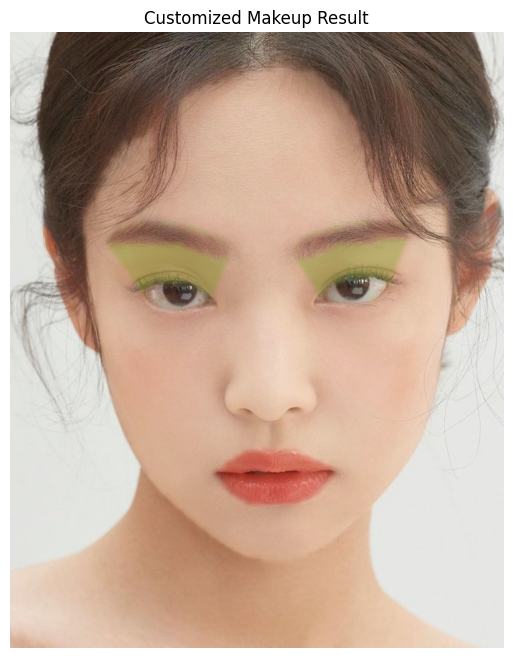

In [4]:
_ = apply_makeup(
    "face_3.jpg",
    skin_color=(255, 230, 200), skin_alpha=0.25,
    lip_color=(240, 20, 0), lip_alpha=0.2,
    eyelid_color=(100, 150, 0), eyelid_alpha=0.3
)